# Full Sample Regression

Packages

In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from   scipy.stats import ttest_1samp

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

Get raw data

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\QualityShocks\root\src")
from FullSampleRegression import FullSampleRegression

keep_tickers = ["europe", "global", "global_ex_usa", "pacific", "usa"]
df           = (FullSampleRegression().get_full_sample_ols().query(
    "variable == @keep_tickers"))

## Raw QMJ Daily Returns

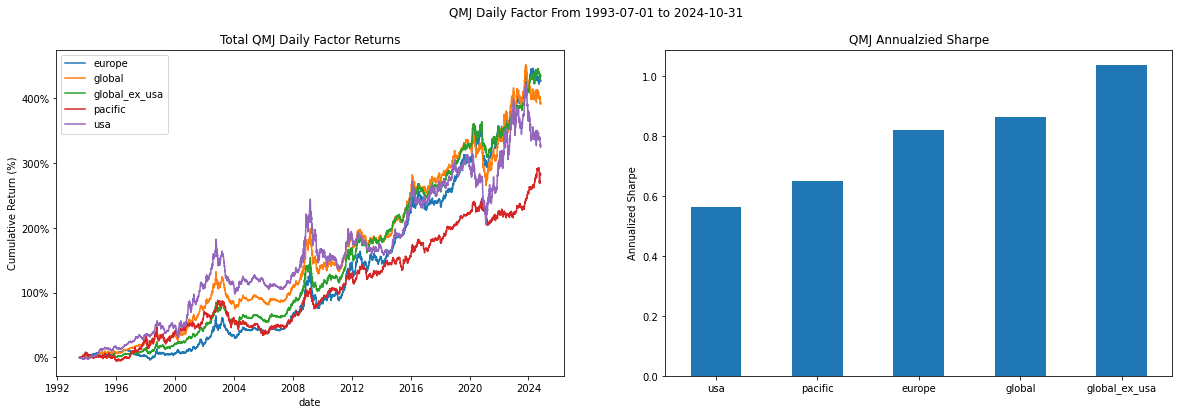

In [3]:
def plot_rtn(df: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_wider = (df.rename(
        columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "value").
        dropna())

    df_sharpe = (df_wider.mean() / df_wider.std() * np.sqrt(252)).to_frame(name = "sharpe").sort_values("sharpe")

    (df_wider.apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes[0],
            title  = "Total QMJ Daily Factor Returns",
            ylabel = "Cumulative Return (%)"))

    (df_sharpe.plot(
        ax     = axes[1],
        legend = False,
        kind   = "bar",
        title  = "QMJ Annualzied Sharpe",
        ylabel = "Annualized Sharpe",
        rot    = 0))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    fig.suptitle("QMJ Daily Factor From {} to {}".format(
        df_wider.index.min(),
        df_wider.index.max()))
    
plot_rtn(df)

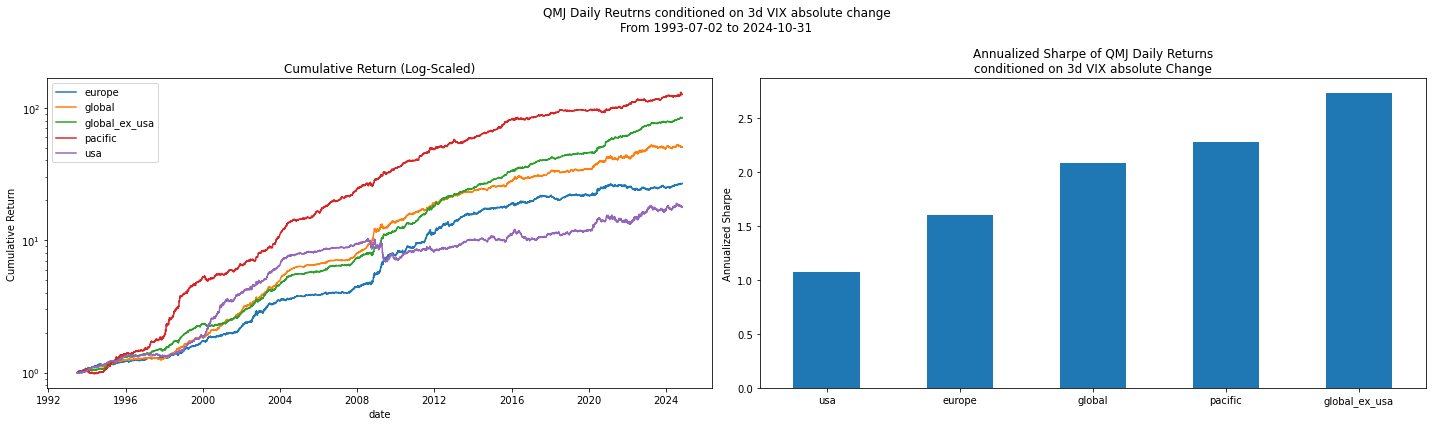

In [12]:
def plot_vix_rtn(df: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_wider = (df.rename(
        columns = {"variable": ""}).
        assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.value).
        pivot(index = "date", columns = "", values = "signal_rtn").
        dropna())


    df_sharpe = (df_wider.mean() / df_wider.std() * np.sqrt(252)).to_frame(name = "sharpe").sort_values("sharpe")

    (df_wider.apply(
        lambda x: np.cumprod(1 + x)).
        plot(
            logy   = True,
            ax     = axes[0],
            ylabel = "Cumulative Return",
            title  = "Cumulative Return (Log-Scaled)"))

    (df_sharpe.plot(
        kind   = "bar",
        ax     = axes[1],
        rot    = 0,
        legend = False,
        ylabel = "Annualized Sharpe",
        title  = "Annualized Sharpe of QMJ Daily Returns\nconditioned on 3d VIX absolute Change"))

    fig.suptitle("QMJ Daily Reutrns conditioned on 3d VIX absolute change\nFrom {} to {}".format(
        df_wider.index.min(),
        df_wider.index.max()))

    plt.tight_layout()
    
plot_vix_rtn(df)

## Compare Results

In [5]:
def get_sharpe_comparison(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.assign(
        signal_rtn = lambda x: np.sign(x.lag_resid) * x.value)
        [["variable", "date", "value", "signal_rtn"]].
        rename(columns = {
            "variable": "region",
            "value"   : "rtn"}).
        melt(id_vars = ["date", "region"]).
        drop(columns = ["date"]).
        groupby(["region", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_sharpe = get_sharpe_comparison(df)

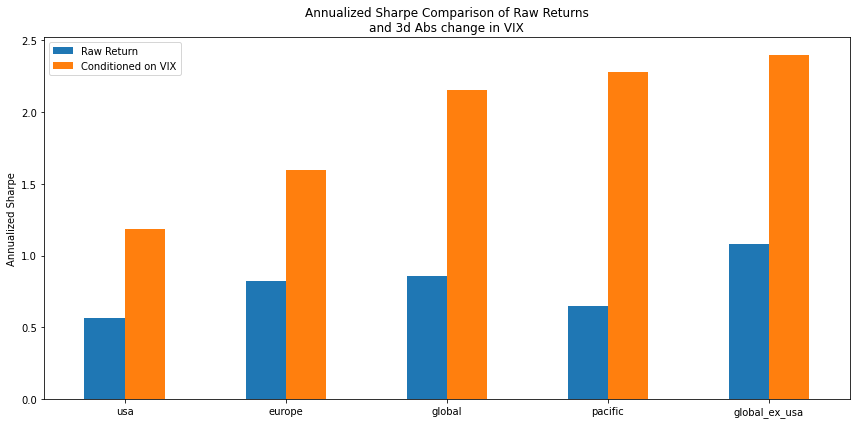

In [6]:
def plot_shapre(df_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "region", columns = "", values = "sharpe").
        sort_values("signal_rtn").
        rename(columns = {
            "rtn": "Raw Return",
            "signal_rtn": "Conditioned on VIX"}).
        plot(
            figsize = (12,6),
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe Comparison of Raw Returns\nand 3d Abs change in VIX"))
    
    plt.tight_layout()
    
plot_shapre(df_sharpe)

In [7]:
def _get_spread(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.set_index(
        "date").
        sort_index().
        assign(signal_rtn = lambda x: np.sign(x.lag_resid) * x.value)
        [["value", "signal_rtn"]])
    
    df_sharpe = df_out.rolling(window = 30).mean() / df_out.rolling(window = 30).std() * np.sqrt(252)
    df_spread = (df_sharpe.assign(
        spread = lambda x: x.signal_rtn - x.value).
        dropna())
    
    t_test, p_value = (ttest_1samp(
        a       = df_spread.spread,
        popmean = 0))
    
    t_dict = {
        "mean_val": df_spread.spread.mean(),
        "t_stat"  : t_test,
        "p_value" : p_value}
    
    df_out = (pd.DataFrame.from_dict(
        data    = t_dict, 
        orient  = "index",
        columns = ["value"]))
    
    return df_out

def get_sharpe_comparison(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.groupby(
        "variable").
        apply(_get_spread).
        reset_index().
        rename(columns = {"level_1": "param"}))
    
    return df_out

df_sharpe_compare = get_sharpe_comparison(df)

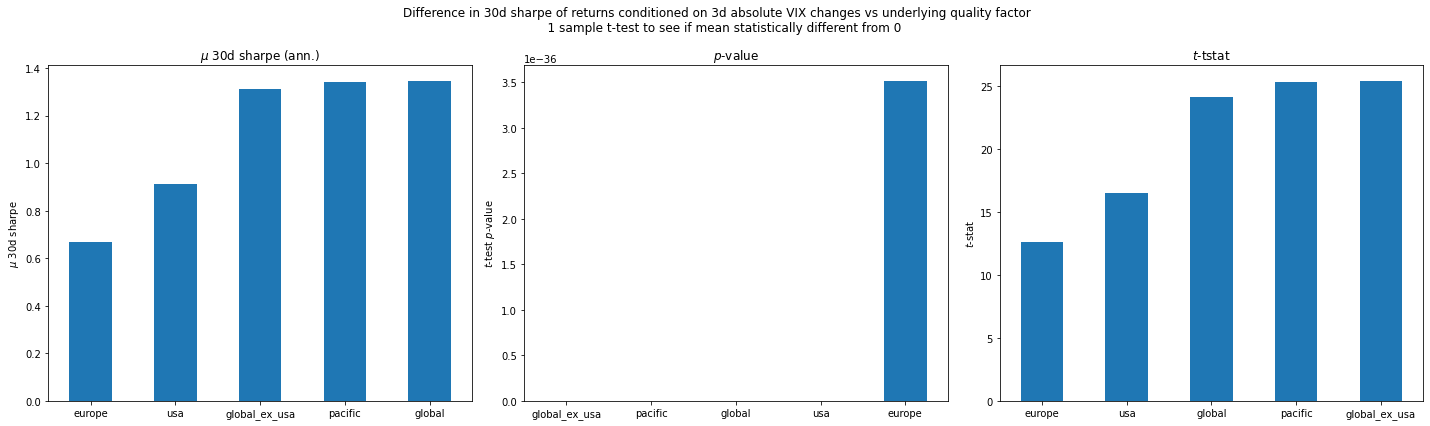

In [8]:
def plot_tstat(df_sharpe_compare: pd.DataFrame) -> plt.Figure: 
    
    params    = df_sharpe_compare.param.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(params), figsize = (20,6))

    title_renamer = {
        "mean_val": r"$\mu$ 30d sharpe (ann.)",
        "p_value" : r"$p$-value",
        "t_stat"  : r"$t$-tstat"}

    ylabel_renamer = {
        "mean_val": r"$\mu$ 30d sharpe",
        "p_value" : r"$t$-test $p$-value",
        "t_stat"  : r"$t$-stat"}

    for param, ax in zip(params, axes.flatten()):

        (df_sharpe_compare.query(
            "param == @param").
            set_index("variable").
            sort_values("value").
            plot(
                ax     = ax,
                kind   = "bar",
                xlabel = "",
                ylabel = ylabel_renamer[param],
                title  = title_renamer[param],
                legend = False,
                rot    = 0))

    fig.suptitle('''Difference in 30d sharpe of returns conditioned on 3d absolute VIX changes vs underlying quality factor
    1 sample t-test to see if mean statistically different from 0''')
    plt.tight_layout()
    
plot_tstat(df_sharpe_compare)

## The regression

In [9]:
def _get_ols_params(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.set_index(
        "date").
        sort_index())

    model = (sm.OLS(
        endog = df_tmp.value,
        exog  = sm.add_constant(df_tmp.VIX_shock)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index())
    
    df_out = (model.pvalues.to_frame(
        name = "pval").
        reset_index().
        merge(right = df_val, how = "inner", on = ["index"]))
    
    return df_out
    
def get_params(df) -> pd.DataFrame: 

    df_out = (df.groupby(
        "variable").
        apply(_get_ols_params).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out

df_params = get_params(df)

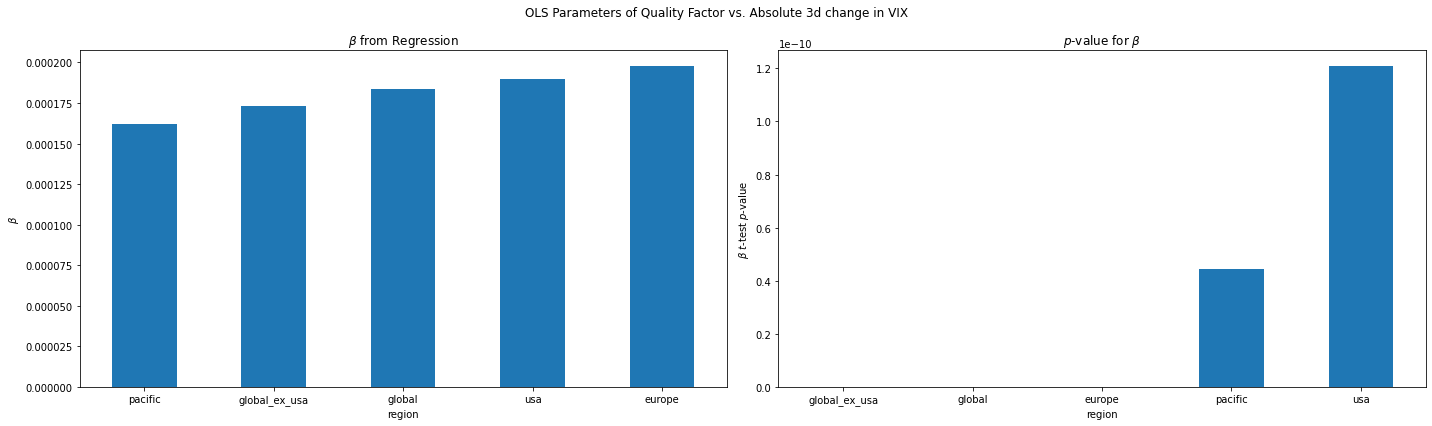

In [10]:
def plot_params(df_params: pd.DataFrame) -> plt.Figure:
    
    df_longer = (df_params.rename(
        columns = {"variable": "region"}).
        melt(id_vars = ["region", "index"]).
        query("index == 'VIX_shock'"))

    variables = df_longer.variable.drop_duplicates().sort_values(ascending = False).to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        df_plot = (df_longer.query(
            "variable == @variable").
            set_index("region")
            [["value"]].
            sort_values("value"))

        (df_plot.plot(
            ax     = ax,
            kind   = "bar",
            legend = False,
            rot    = 0))

        if variable == "pval": 
            ax.set_ylabel(r"$\beta$ $t$-test $p$-value")
            ax.set_title(r"$p$-value for $\beta$")

        else: 
            ax.set_ylabel(r"$\beta$")
            ax.set_title(r"$\beta$ from Regression")

    fig.suptitle("OLS Parameters of Quality Factor vs. Absolute 3d change in VIX")
    plt.tight_layout()
    
plot_params(df_params)